# **Classical interval estimation, limits, systematics Lecture 2 : exercises notebook**

This is the companion notebook to lecture 1 in the _Classical interval estimation, limits and systematics_ course, covering the following topics:

1. Parameter estimation using likelihood methods
3. Maximum likelihood in the Gaussian case and chi2
4. Hypothesis testing basics

First perform the usual imports:

In [1]:
import numpy as np
import scipy.stats
from matplotlib import pyplot as plt

## 1. Parameter estimation using likelihood methods

In the previous lecture, we have applied hypothesis testing to a bin-counting experiment:

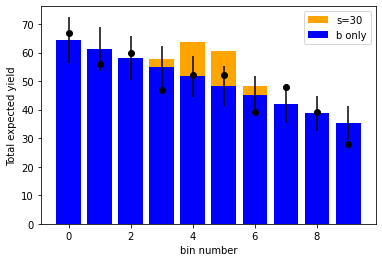

In [2]:
nbins = 10
x = np.linspace(0, nbins - 1, nbins)

# The background follows a linear shape
b_yields = np.array([ (1 - i/2/nbins) for i in range(0, nbins) ])
b_fracs = b_yields/np.sum(b_yields)

# The signal shape is a peak
s_fracs = np.zeros(nbins)
s_fracs[3:7] = [ 0.1, 0.4, 0.4, 0.1 ]

# Now generate some data for s=10
s = 10
b = 500
s_and_b = s*s_fracs + b*b_fracs
b_only = b*b_fracs
np.random.seed(102) # make sure we always generate the same
data = [ np.random.poisson(s*s_frac + b*b_frac) for s_frac, b_frac in zip(s_fracs, b_fracs) ]

# And define the model for s=30
s30_and_b = 30*s_fracs + b*b_fracs

# And finally plot everything
plt.bar(x, s30_and_b, color='orange', label='s=30')
plt.bar(x, b_only, color='b', yerr=np.sqrt(b_only), label='b only')
plt.scatter(x, data, zorder=10, color='k')
plt.xlabel('bin number')
plt.ylabel('Total expected yield')
plt.legend();

There are some fluctuations in the data, but it seems that the $s$ is a bit smaller than the $s=30$ shown in orange (note that we cheated and generated the data for $s=10$, so this is not unexpected!). We can use the tools defined in the previous lecture to find the best-fit $s$:

In [3]:
# ==> First define the log-likelihood function lambda = -2 log L as in the previous class 
def lambda_s(s_hypo, data) :
    return sum( [ -2*np.log(scipy.stats.poisson.pmf(n, s_hypo*s_frac + b*b_frac)) for n, s_frac, b_frac in zip(data, s_fracs, b_fracs) ] )

from scipy.optimize import minimize_scalar

def best_fit_s(data) :
    return scipy.optimize.minimize_scalar(lambda s : lambda_s(s, data), bracket=(-10,20)).x

We are going to compute confidence intervals on the a signal yield $s$ use the likelihood-based discriminant
$$
t(s) = -2 \log \frac{L(s)}{L(\hat{s})}
$$
following the same principle as for discovery. Define it:

In [4]:
def t_s(s) :
    return lambda_s(s, data) - lambda_s(best_fit_s(data), data)


Now plot it:

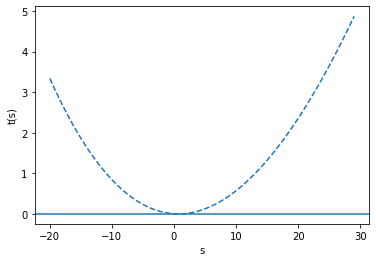

In [5]:
s_vals = np.arange(-20,30,1)
plt.plot(s_vals, [ t_s(s_val) for s_val in s_vals ], linestyle='--')
plt.xlabel('s')
plt.ylabel('t(s)')
plt.axhline(0)

You should find a parabola, which is expected for a near-Gaussian case. A quick computation will show that for a Gaussian likelihood $\hat{s} \sim G(s, \sigma_s)$, one has
$$
t(s) = \left(\frac{s - \hat{s}}{\sigma_s}\right)^2
$$
which explains the parabola.

In this Gaussian case, the $\pm 1\sigma$ uncertainties are reached for $t(s)=1$. We will assume that this still holds true also in not-so-Gaussian cases, so that we **define** the uncertainties using the crossings with $t(s)=1$:

positive edge = 13.0729, negative edge = -10.9245
68.3% interval : 0.7056301019975916 + 12.367257484718937 - 11.630169800024953


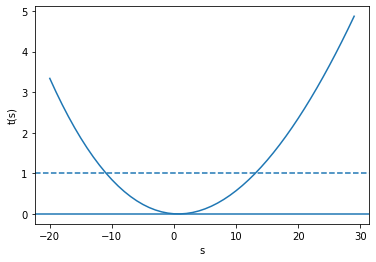

In [6]:
plt.plot(s_vals, [ t_s(s_val) for s_val in s_vals ])
plt.xlabel('s')
plt.ylabel('t(s)')
plt.axhline(0)

# Draw the t(s) = 1 line for illustration
plt.axhline(1, linestyle='--');

s_hat = best_fit_s(data)
s_neg = scipy.optimize.root_scalar(lambda s : t_s(s) - 1, bracket=(-20,0)).root
s_pos = scipy.optimize.root_scalar(lambda s : t_s(s) - 1, bracket=(0,30)).root
print('positive edge = %g, negative edge = %g' % (s_pos, s_neg))
print ('68.3% interval :', s_hat, '+', s_pos - s_hat, '-', s_hat - s_neg)

This defines a type of confidence intervals called *likelihood intervals* which are not quite exact in the non-Gaussian case but are an excellent approximation to the exact solution. This is because some non-Gaussian effects are accounted for in the expression of $t(s)$, which here uses a Poisson expression, so this is a better approximation than just assuming that everything is Gaussian. This type of technique is usually referred to as an *asymptotic approximation*, and we'll see a similar example below for the limits.

## 2.  Limit-setting using likelihoods

Measuring the signal is useful when it is large, but when it is very small it can be more interesting to set an upper limit on it. This means computing the value of the signal yield that is large enough to be excluded with a given confidence level, typically 95%.

This "95%" means that if we would repeat the experiment many times, the true signal would be below the limit 95% of the time.  This is represented in the picture below, with the shaded area corresponding to 5% of the integral.

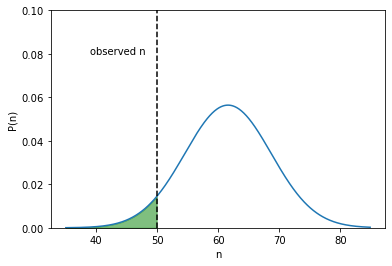

In [7]:
n = 50
sigma = np.sqrt(n)
ns = np.arange(35,85,0.1)
plt.plot(ns, scipy.stats.norm.pdf(ns, loc=n + 1.64*sigma, scale=sigma))
plt.ylim(0,0.1)
plt.xlabel('n')
plt.ylabel('P(n)')

up = 1
shaded_ns = np.arange(35, n, 0.1)
plt.fill_between(shaded_ns, scipy.stats.norm.pdf(shaded_ns, loc=n + 1.64*sigma, scale=sigma), alpha=0.5, color='g')
#plt.axvline(x=n + 1.64*sigma, linestyle='--', color='k')
plt.axvline(x=n, linestyle='--', color='k')
#plt.text(n + 1.64*sigma + 2, 0.08, 's95 + b')
plt.text(n - 11, 0.08, 'observed n');

As it says above, the upper limits is about $1.64\sigma$ above the observed value, in the Gaussian case. Can you compute this number exactly ?

In [8]:
# First find the position on the Gaussian corresponding to a 5%  quantile
z_5 = scipy.stats.norm.isf(0.05)
print(z_5)


1.6448536269514729


Now let's apply limit-setting on the same multi-bin example we already used for interval estimation above. This is justified here, since from the previous section we know the signal is not large -- setting an upper limit makes sense in this situation.

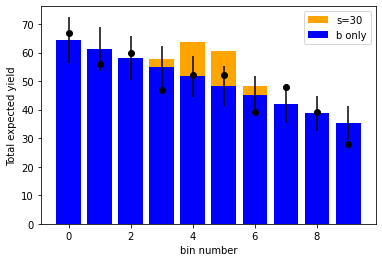

In [9]:
# Plot the model again, for s=30
plt.bar(x, s30_and_b, color='orange', label='s=30')
plt.bar(x, b_only, color='b', yerr=np.sqrt(b_only), label='b only')
plt.scatter(x, data, zorder=10, color='k')
plt.xlabel('bin number')
plt.ylabel('Total expected yield')
plt.legend();

As usual, we use the likelihood-based discriminant
$$
t(s)  = -2 \log \frac{L(s)}{L(\hat{s})}
$$

The only difference compared to parameter measurement is that we will only consider the positive side of the distribution, $s > \hat{s}$, since we are looking for an *upper* limit. 

As we saw before, for the Gaussian case we have
$$
t(s) = \left(\frac{s - \hat{s}}{\sigma_s}\right)^2
$$
so that the limit is reached for $t(s) = 1.64^2$, where $\Phi\left(\sqrt{t(s)}\right) = 0.05$

As for the intervals, we will assume that the relation above is always valid (even if of course our model is not exactly Gaussian). So we will define our limit $s_{95}$ as  $\Phi\left(\sqrt{t(s_{95})}\right) = 0.05$. Remember, this still accounts for non-Gaussianity through the expression of $t(s)$, and usually provides an excellent approximation to the true limit. As for the intervals, this is referred to as the *asymptotic* approximation.

      converged: True
           flag: 'converged'
 function_calls: 9
     iterations: 8
           root: 21.444510816556857

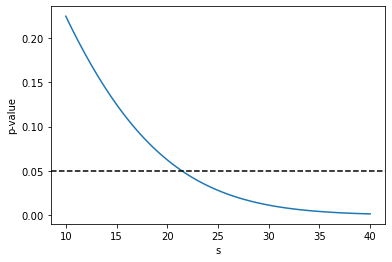

In [10]:
s_vals = np.linspace(10, 40, 100)

plt.plot(s_vals, scipy.stats.norm.sf(np.sqrt(t_s(s_vals))))
plt.xlabel('s')
plt.ylabel('p-value')
plt.axhline(0.05, linestyle='--', color='k')
scipy.optimize.root_scalar(lambda s : scipy.stats.norm.sf(np.sqrt(t_s(s))) - 0.05, bracket=(20,40) )

## 3. Profiling

We have discussed 3 types of statistical results:
* Testing for discovery
* Computing confidence intervals for parameters (central value +/- uncertainty)
* Setting upper limits

For simplicity, all this was done using models with only 1 parameter (the signal $s$), which was the *parameter of interest*. Models usually also have additional *nuisance parameters* which aren't interesting in themselves, but need to be included to describe the data.

These parameters need to be included in the treatment, but fortunately this is quite easy in the likelihood ratio framework. The basic quantity we used before was
$$
t(s) = -2 \log \frac{L(s)}{L(\hat{s})}
$$

This allows to compare 2 hypotheses:
* The free hypothesis $\hat{s}$ which corresponds to the best-fit $s$ in the data.
* The fixed hypothesis $s$ (for instance $s=0$ for discoveries)

If we have an additional nuisance parameter $\theta$, the likelihood is now a function of both parameters: $L(s, \theta)$. How do we set $\theta$ ? The interesting answer is that in both cases, we use the best-fit value of $\theta$ :
* For the free hypothesis $\hat{s}$, we use $\hat{\theta}$, the best-fit value of $\theta$.
* For the fixed hypothesis $s$, we use $\hat{\hat{\theta}}(s)$, the best-fit value of $\theta$ at a fixed $s$.

So in the end we use
$$
t(s) = -2 \log \frac{L(s, \hat{\hat{\theta}}(s))}{L(\hat{s},\hat{\theta})}
$$
with the appropriate best-fit values. This is now called the *profile likelihood*.

A very nice feature of this is that $t(s)$ is still a function only of $s$, so we can perform the rest of the computation in the same way as before. The only difference is that we need to compute best-fit values for $\theta$ in order to compute the appropriate ilikelihood values.


We reuse the same example as in the previous sections

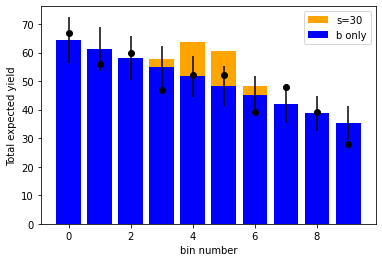

In [11]:
plt.bar(x, s30_and_b, color='orange', label='s=30')
plt.bar(x, b_only, color='b', yerr=np.sqrt(b_only), label='b only')
plt.scatter(x, data, zorder=10, color='k')
plt.xlabel('bin number')
plt.ylabel('Total expected yield')
plt.legend();

For simplicity, we will focus on the single-bin measurement in bin 4:

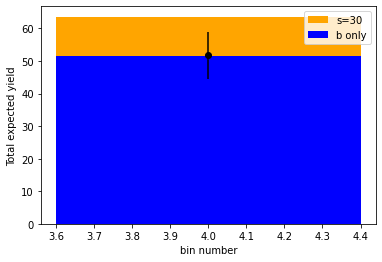

In [12]:
sb4 = s30_and_b[4]
b4 = b_only[4]
n4 = data[4]
plt.bar(x[4], sb4, color='orange', label='s=30')
plt.bar(x[4], b4, color='b', yerr=np.sqrt(b_only[4]), label='b only')
plt.scatter(x[4], n4, zorder=10, color='k')
plt.xlabel('bin number')
plt.ylabel('Total expected yield')
plt.legend();

As in the previous exercise, we can measure $s$ here using the likelihood technique, computing the crossings with $t(s)=1$. Let's do it:

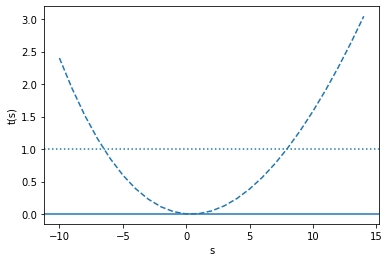

In [13]:
s_vals = np.arange(-10,15,1)

def lambda_s(s_val,b_val) : 
   return -2*np.log(scipy.stats.poisson.pmf(n4, s_val+b_val))

def t_s(s, b) :
    best_fit_s = scipy.optimize.minimize_scalar(lambda s : lambda_s(s, b), bracket=(-10,20)).x
    return lambda_s(s, b) - lambda_s(best_fit_s, b)
    
plt.plot(s_vals, [ t_s(s_val, b4) for s_val in s_vals ], linestyle='--')
plt.xlabel('s')
plt.ylabel('t(s)')
plt.axhline(0)
plt.axhline(1, linestyle=':')


We introduce a new ingredient: the background level $b_4$ is now not a fixed number, but only known up to an uncertainty, say $\sigma_b = \pm 2$. We assume here that it is Gaussian-distributed, so that the full likelihood is
$$
L(s, b) = P(n_4; s_4 + b_4) G(b^{\text{aux}}, b_4, \sigma_b)
$$

where the first term is the Poisson PDF we had before, and the Gaussian is a new term giving the PDF for $b_4$. The central value of the $b_4$ constraint is $b^{\text{aux}}$, which is a kind of observable: we can assume that our knowledge of $b_4$ comes from a separate "auxiliary" experiment which observed $b^{\text{aux}}$ with an uncertainty $\sigma_b$, and we use this to constrain $b_4$ in the experiment here. 

In practice the constraint on $b_4$ can also come from Monte-Carlo simulation, an independent theory prediction, etc., but in this case we can anyway use the same formalism, and set $b^{\text{aux}}$ to the nominal prediction and $\sigma_b$ to its uncertainty.

Here we'll set $b^{\text{aux}}$ to our original background value, which is what we take as nominal:

In [14]:
baux = b_only[4]
sigmab = 3

Now we compute the profile likelihood, with $s$ as our parameter of interest, and $b$ the nuisance parameter. 

First we define $\lambda(s,b) = -2\log L(s,b)$, where $L(s,b)$ is the product of two terms:
* The usual Poisson PDF for the one-bin counting process
* The Gaussian representing the constraint on $b$, with an observable $b_{\text{aux}}$, a mean $b$, and a width $\sigma_b$.

Secondly, we define the *profiled* version of the above, where $b$ is set to its best-fit value. To define it, we first must compute the best-fit $\hat{\hat {b}}(s)$ for a given $s$, by minimizing $\lambda(s,b)$ for a fixed value of $s$. Then the profile likelihood is defined as $\lambda(s) = -2\log L(s,\hat{\hat {b}}(s))$.

Finally, the $t(s)$ function is defined as usual as $t(s) = \lambda(s) - \lambda(\hat{s})$, after computing the best-fit $\hat{s}$ which minimizes $\lambda(s)$. 


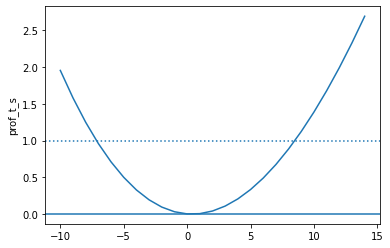

In [15]:
def lambda_sb(s_val,b_val) : 
   return -2*np.log(scipy.stats.poisson.pmf(n4, s_val+b_val)*scipy.stats.norm.pdf(baux, b_val, sigmab))

def prof_lambda_s(s_val) :
    best_fit_b = scipy.optimize.minimize_scalar(lambda b_val : lambda_sb(s_val,b_val), bracket=(30,50)).x
    return lambda_sb(s_val, best_fit_b)

def prof_t_s(s_val) :
    best_fit_s = scipy.optimize.minimize_scalar(prof_lambda_s, bracket=(-10,20)).x
    return prof_lambda_s(s_val) - prof_lambda_s(best_fit_s)
    
plt.plot(s_vals, [ prof_t_s(s_val) for s_val in s_vals ])
plt.axhline(0)
plt.axhline(1, linestyle=':')
plt.ylabel('prof_t_s');


This looks again quite parabolic, and similar to what we had just before without background uncertainty. Just to check, we can compare the two cases

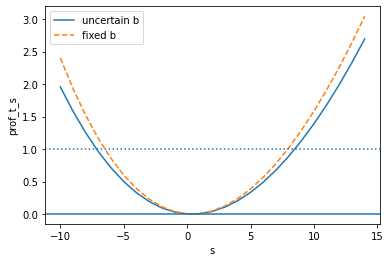

In [16]:
plt.plot(s_vals, [ prof_t_s(s_val) for s_val in s_vals ], label='uncertain b')
plt.plot(s_vals, [ t_s(s_val, b4) for s_val in s_vals ], linestyle='--', label='fixed b')
plt.xlabel('s')
plt.ylabel('prof_t_s')
plt.axhline(0)
plt.axhline(1, linestyle=':')
plt.legend();

So everything works as expected : we get the same result as before, but the size of the confidence interval went up since now the background adds a new source of uncertainty. As before, we could compute the crossings with $t=1$ to get the precise values of the uncertainties in each case.

To see a bit better what is happening, we can check the values of the best-fit $b$ for different $s$ values:

In [17]:
print('b4 = ', b4)
print('best_fit_b @ s=0.7 =', scipy.optimize.minimize_scalar(lambda b : lambda_sb(s_val=0.7,b_val=b), bracket=(30,50)).x)
print('best_fit_b @ s=-10 =', scipy.optimize.minimize_scalar(lambda b : lambda_sb(s_val=-10,b_val=b), bracket=(30,50)).x)
print('best_fit_b @ s=+10 =', scipy.optimize.minimize_scalar(lambda b : lambda_sb(s_val=+10,b_val=b), bracket=(30,50)).x)

b4 =  51.61290322580645
best_fit_b @ s=0.7 = 51.56693832219788
best_fit_b @ s=-10 = 53.39704704146979
best_fit_b @ s=+10 = 50.36565595945177


At the best-fit point $s=0.7$, the best-fit background is the nominal one. However if we take a lower $s$ value $s=-10$, we get a higher best-fit $b$. And if we push $s$ up, $b$ goes down. What happens is that $b$ is adjusting to $s$, and partially compensating for the the fact that these values of $s$ don't quite agree with the data. This extra adjustment makes it more difficult to exclude values of $s$ away from $\hat{s}$, so that the allowed range of $s$ gets larger -- and therefore the uncertainties get larger as well.

## 4. Bayesian methods: simple case

The methods we have seen so far are *frequentist*. This in effect means that there are 2 difference classes of parameters
* Observables, which are randomly given by the experiment.
* Parameters, which always have a unique, fixed value -- which is known, or more often unknown.

There is another class of methods, *Bayesian* methods, which have a different take on measurement. In this approach, everything is random:
* Observables are random as before
* Parameters are also considered random, with the associated PDF used to quantify the uncertainty on their values.

So for instance, for a Gaussian measurement:
* The frequentist approach is to say $s = 2 +/- 3$, meaning that the interval $[-1, 5]$ has a 68% chance of containing the true value of $s$
* The Bayesian approach is to say that $s \sim G(2, 3)$, where the Gaussian encodes the same information.

One thing to note is that in the frequentist setting, "$[-1, 5]$ has a 68% chance of containing the true value of $s$" is a statement on the interval itself, which is defined for a given experiment: another experiment would find another interval, and 68% of these intervals are guaranteed to contain the true value. For the Bayesian approach, the value of $s$ is itself random, and the experiment is just a way to gather more information on its distribution.

The fundamental tool of Bayesian inference is Bayes' theorem. It can be written as
$$
P(s) \propto L(s; n) \pi(s)
$$
where 
* $\pi(s)$ is the *prior* PDF -- a PDF giving the knowledge of $s$ that we had before the experiment
* $L(s;n)$ is the usual likelihood
* $P(s)$ is the *posterior* PDF on $s$, i.e. the distribution that encodes our knowledge of $s$ including the experimental information.

A limit on $s$ can then be set by integrating the posterior $P(s)$ and finding $s_{up}$ so that $\int^{s_{up}} P(s) ds = 95\%$.

Consider the example we had before:

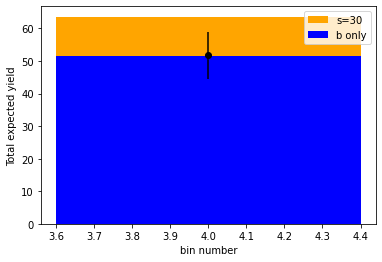

In [18]:
plt.bar(x[4], sb4, color='orange', label='s=30')
plt.bar(x[4], b4, color='b', yerr=np.sqrt(b_only[4]), label='b only')
plt.scatter(x[4], n4, zorder=10, color='k')
plt.xlabel('bin number')
plt.ylabel('Total expected yield')
plt.legend();

and assume we have a flat prior on $s$, $\pi(s) = k$. Flat priors are often used in Bayesian applications, since they provide a relatively unbiased starting point.
(Note that technically the flat distribution is not well defined if the range of $s$ is infinite, but this won't crea te problems here).

Now we can derive the upper limit:

Bayesian limit = 13.928676511770446


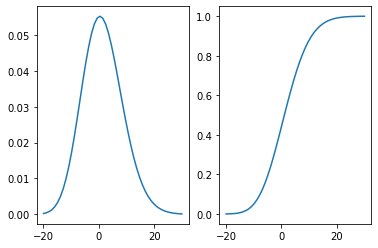

In [19]:
def p_s(s_val) :
  return scipy.stats.poisson.pmf(n4, s_val + b4)

import scipy.integrate

def integral_s(s_val) :
    return scipy.integrate.quad(p_s, -20, s_val)[0]

s_vals = np.linspace(-20,30,50)
plt.subplot(121)
plt.plot(s_vals, [ p_s(s_val) for s_val in s_vals ])
plt.subplot(122)
plt.plot(s_vals, [ integral_s(s_val) for s_val in s_vals ])
s_limit = scipy.optimize.root_scalar(lambda s : integral_s(s) - 0.95, bracket=[0, 30]).root
print('Bayesian limit =', s_limit);

## 4. Bayesian methods: nuisance parameters

Models usually also include nuisance parameters. For instance we considered a one-bin model where the background was only defined up to an uncertainty, so that the full likelihood is
$$
L(s, b) = P(n_4; s_4 + b_4) G(b^{\text{aux}}, b_4, \sigma_b)
$$

The way to treat this in a Bayesian way is to integrate over the nuisance parameters: formally
$$
P(s) \propto \int L(s, b; n) \pi(s) G(b) db
$$
So that the constraint becomes the prior PDF of $b$. Using an uncertainty of $5$ on the background, and a central value equal to $b_4$, we have

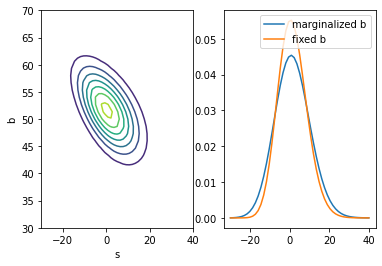

In [20]:
def p_sb(s_val, b_val) :
  return scipy.stats.poisson.pmf(n4, s_val + b_val)*scipy.stats.norm.pdf(b_val, loc=b4, scale=5)

def integral_intb(s_val) :
    return scipy.integrate.quad(lambda b : p_sb(s_val, b), 30, 70)[0]

def integral_sb(s_val) :
    return scipy.integrate.quad(integral_intb, -25, s_val)[0]

s_vals = np.linspace(-30,40,51)
b_vals = np.linspace(30,70,31)
s_mesh,b_mesh = np.meshgrid(s_vals, b_vals)
plt.subplot(121)
plt.contour(s_mesh, b_mesh, p_sb(s_mesh, b_mesh) )
plt.xlabel('s')
plt.ylabel('b')
plt.subplot(122)
plt.plot(s_vals, [ integral_intb(s_val) for s_val in s_vals ], label='marginalized b')
plt.plot(s_vals, [ p_s(s_val) for s_val in s_vals ], label='fixed b');
plt.legend();

Bayesian limit = 16.357666865038734


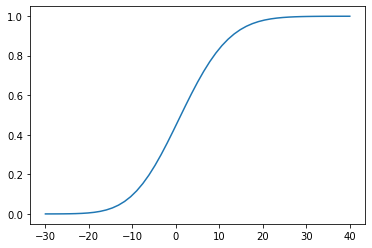

In [21]:
plt.plot(s_vals, [ integral_sb(s_val) for s_val in s_vals ]);
s_limit = scipy.optimize.root_scalar(lambda s : integral_sb(s) - 0.95, bracket=[0, 20]).root
print('Bayesian limit =', s_limit)

As expected, the limit is slightly larger than in the no-systematics case.